In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import random
from IPython.display import display
from sklearn import preprocessing
from missingpy import MissForest

## Hands-On

We "transformed" the Adult dataset into a new dataset without "?", assuming its name as dataset D (represented by D or df in the code) by removing all rows with "?". And now, we will test 3 different scenarios, being this part of the whole code one of them.

In [2]:
columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']
df_train = pd.read_csv("../Fair-Explainable-Analytics-Seminar/data/D_train.csv", header=0, names=columns)
df_test = pd.read_csv("../Fair-Explainable-Analytics-Seminar/data/D_test.csv", header=0, names=columns)

#### 3 - Some Numerical values removed
Randomly drop some values from some numerical features of this dataset D, just on test set, to be possible for the model learn in the train set.

In [38]:
# Randomly remove some values

# select some / all columns and just set 50% of values missing -> test
num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

random.seed(36)
n = random.randint(1, len(num_features)) #number of columns to select
print(n)

selected_columns = []
for i in range(0,n):
    a = random.randint(0,len(num_features)-1) # select a column randomly
    if num_features[a] not in selected_columns: # to not repeat columns
        selected_columns.append(num_features[a]) # append column name to the list
    else: # if the column choosen is already in the list
        b = 0
        while b == 0:
            a = random.randint(0,len(num_features)-1) # select another column randomly
            if num_features[a] not in selected_columns: # to not repeat columns
                selected_columns.append(num_features[a]) # append column name to the list
                b = 1 # repeat this until the column choosen is not in the list 
        
print("Selected columns to remove values: " + str(selected_columns))

count = 0
for i in selected_columns:
    for j in df_test[i]:
        count += 1

print("Total number of values inside the selected columns: "+str(count))
number = int(0.50*count)
print("Number of values to be removed: "+str(number))

idx_test = df_test.index
for i in range(0, number):
    b = random.randint(0, len(selected_columns)-1)
    c = random.randint(0, len(idx_test)-1)
    if  df_test[selected_columns[b]][idx_test[c]] != "NaN":
        df_test.loc[idx_test[c], selected_columns[b]] = "NaN"
    else:
        d = 0
        while d == 0:
                b = random.randint(0, len(selected_columns)-1)
                c = random.randint(0, len(idx_test)-1)
                if  df_test[selected_columns[b]][idx_test[c]] != "NaN":
                    df_test.loc[idx_test[c], selected_columns[b]] = "NaN"
                    d = 1

# to check if there are "number" missing values
sum = 0
for row in df_test.iterrows():
    for j in row[1]:
        if j == "NaN":
            sum += 1
print("Number of values removed: "+str(sum))
print("Percentage of missing values, having in account the selected columns in test set: "+str((sum/count)*100)+"%")
# this does not forbid having more than one missing value per index - there are index with more than one missing value

df_test.to_csv("../Fair-Explainable-Analytics-Seminar/data_removed/df_test_3")

3
Selected columns to remove values: ['age', 'education-num', 'capital-loss']
Total number of values inside the selected columns: 18138
Number of values to be removed: 9069
Number of values removed: 9069
Percentage of missing values, having in account the selected columns in test set: 50.0%


After dropped some values from the test set of D, we will impute them with the MissForest trained on the training set of D, obtaining a new complete dataset D' (named df2 in the code).

In [39]:
# Label encodes the set of the features to be used for imputation
def label_encoding(df, columns): #df: data frame (processed data), columns: list (features to be encoded)
    
    encoders = dict()
    for col_name in columns:
        series = df[col_name]
        label_encoder = preprocessing.LabelEncoder()
        df[col_name] = pd.Series(
            label_encoder.fit_transform(series[series != "NaN"]),
            index=series[series != "NaN"].index
        )
        encoders[col_name] = label_encoder
    return encoders # Returns a dictionary



In [40]:
df_train
# without unknown values 

age workclass  fnlwgt     education  education-num      marital-status  \
0       46   Private  415051  Some-college             10  Married-civ-spouse   
1       28   Private   76129       HS-grad              9       Never-married   
3       43   Private  160369       HS-grad              9       Never-married   
5       39   Private  160623    Assoc-acdm             12       Never-married   
6       39   Private  706180     Bachelors             13            Divorced   
...    ...       ...     ...           ...            ...                 ...   
26043   32   Private  176992          10th              6       Never-married   
26044   40   Private   55191  Some-college             10       Never-married   
26045   79   Private  124744  Some-college             10  Married-civ-spouse   
26046   50   Private  192203          11th              7  Married-civ-spouse   
26047   19   Private  104112       HS-grad              9       Never-married   

              occupation    relationship   race     sex  capital-gain  \
0                  Sales         Husband  Black    Male             0   
1      Machine-op-inspct       Unmarried  White  Female             0   
3      Machine-op-inspct       Own-child  White    Male             0   
5           Craft-repair       Own-child  White    Male             0   
6                  Sales       Unmarried  White  Female             0   
...                  ...             ...    ...     ...           ...   
26043       Craft-repair       Unmarried  White    Male             0   
26044       Adm-clerical   Not-in-family  Black  Female             0   
26045     Prof-specialty  Other-relative  White    Male             0   
26046   Transport-moving         Husband  White    Male             0   
26047              Sales       Unmarried  Black    Male             0   

       capital-loss  hours-per-week native-country    50K  
0                 0              60  United-States   >50K  
1                 0              40      Guatemala  <=50K  
3                 0              40  United-States  <=50K  
5                 0              40  United-States  <=50K  
6                 0              40  United-States  <=50K  
...             ...             ...            ...    ...  
26043             0              40  United-States  <=50K  
26044             0              40  United-States  <=50K  
26045             0              20  United-States  <=50K  
26046             0              40  United-States  <=50K  
26047             0              30          Haiti  <=50K  

[24116 rows x 15 columns]

In [41]:
## Train set:

# categorical features
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

# label encoding categorical features
encoders = label_encoding(df_train, cat_features)

# train the MissForest
imputer = MissForest()
train_imp = imputer.fit(df_train)

In [42]:
columns_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']
df2_train = pd.DataFrame(df_train, columns =  columns_names)

# decoding the features
for i in cat_features:
    df2_train[i] = encoders[i].inverse_transform(df2_train[i].astype(int))


# to replace floats of numerical features to int as in the original dataset
num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for i in num_features:
        df2_train[i] = df2_train[i].astype(int)
    
display(df2_train)

age workclass  fnlwgt     education  education-num      marital-status  \
0       46   Private  415051  Some-college             10  Married-civ-spouse   
1       28   Private   76129       HS-grad              9       Never-married   
3       43   Private  160369       HS-grad              9       Never-married   
5       39   Private  160623    Assoc-acdm             12       Never-married   
6       39   Private  706180     Bachelors             13            Divorced   
...    ...       ...     ...           ...            ...                 ...   
26043   32   Private  176992          10th              6       Never-married   
26044   40   Private   55191  Some-college             10       Never-married   
26045   79   Private  124744  Some-college             10  Married-civ-spouse   
26046   50   Private  192203          11th              7  Married-civ-spouse   
26047   19   Private  104112       HS-grad              9       Never-married   

              occupation    relationship   race     sex  capital-gain  \
0                  Sales         Husband  Black    Male             0   
1      Machine-op-inspct       Unmarried  White  Female             0   
3      Machine-op-inspct       Own-child  White    Male             0   
5           Craft-repair       Own-child  White    Male             0   
6                  Sales       Unmarried  White  Female             0   
...                  ...             ...    ...     ...           ...   
26043       Craft-repair       Unmarried  White    Male             0   
26044       Adm-clerical   Not-in-family  Black  Female             0   
26045     Prof-specialty  Other-relative  White    Male             0   
26046   Transport-moving         Husband  White    Male             0   
26047              Sales       Unmarried  Black    Male             0   

       capital-loss  hours-per-week native-country    50K  
0                 0              60  United-States   >50K  
1                 0              40      Guatemala  <=50K  
3                 0              40  United-States  <=50K  
5                 0              40  United-States  <=50K  
6                 0              40  United-States  <=50K  
...             ...             ...            ...    ...  
26043             0              40  United-States  <=50K  
26044             0              40  United-States  <=50K  
26045             0              20  United-States  <=50K  
26046             0              40  United-States  <=50K  
26047             0              30          Haiti  <=50K  

[24116 rows x 15 columns]

In [43]:
df_test

age     workclass  fnlwgt     education education-num  \
0      54       Private  175262       7th-8th           NaN   
1      17       Private  295991          10th             6   
2     NaN       Private  240521       HS-grad             9   
3     NaN       Private  236068  Some-college           NaN   
4      35       Private  186934       HS-grad             9   
...   ...           ...     ...           ...           ...   
6508   33  Self-emp-inc  374905       HS-grad           NaN   
6509   41       Private  167106     Bachelors            13   
6510  NaN       Private  223696       1st-4th           NaN   
6511   31       Private  101562       HS-grad           NaN   
6512   51       Private  174754       HS-grad             9   

          marital-status         occupation    relationship  \
0     Married-civ-spouse  Machine-op-inspct         Husband   
1          Never-married       Adm-clerical       Own-child   
2     Married-civ-spouse       Craft-repair         Husband   
3          Never-married              Sales  Other-relative   
4     Married-civ-spouse    Exec-managerial         Husband   
...                  ...                ...             ...   
6508  Married-civ-spouse              Sales         Husband   
6509  Married-civ-spouse       Adm-clerical         Husband   
6510            Divorced       Craft-repair   Not-in-family   
6511  Married-civ-spouse  Machine-op-inspct            Wife   
6512       Never-married      Other-service   Not-in-family   

                    race     sex  capital-gain capital-loss  hours-per-week  \
0                  White    Male             0          NaN              40   
1                  White  Female             0            0              20   
2                  White    Male          7298          NaN              40   
3                  White  Female             0            0              20   
4                  White    Male          7688            0              50   
...                  ...     ...           ...          ...             ...   
6508               White    Male             0          NaN              50   
6509  Asian-Pac-Islander    Male          3103          NaN              35   
6510               Other    Male             0            0              38   
6511               White  Female             0          NaN              55   
6512               Black  Female             0          NaN              38   

          native-country    50K  
0          United-States  <=50K  
1          United-States  <=50K  
2          United-States   >50K  
3          United-States  <=50K  
4          United-States   >50K  
...                  ...    ...  
6508       United-States   >50K  
6509         Philippines   >50K  
6510  Dominican-Republic  <=50K  
6511       United-States  <=50K  
6512       United-States  <=50K  

[6046 rows x 15 columns]

In [44]:
## Test set:

# categorical features
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

# label encoding categorical features
encoders = label_encoding(df_test, cat_features)

# impute the "NaN" values again with the MissForest trained on the train set of D
test_imp = train_imp.transform(df_test)

columns_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']
df2_test = pd.DataFrame(test_imp, columns =  columns_names)

# decoding the features
for i in cat_features:
    df2_test[i] = encoders[i].inverse_transform(df2_test[i].astype(int))


# to replace floats of numerical features to int as in the original dataset
num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for i in num_features:
        df2_test[i] = df2_test[i].astype(int)
    
display(df2_test)


# to check if this method worked
sum = 0
for row in df2_test.iterrows():
    for j in row[1]:
        if j == "NaN":
            sum += 1
print("Number of missing values in test set after MissForest-Imputation: "+str(sum))
# 0 missing values as it should be - indicates that MissFores-Imputation worked because now we don't have missing values, instead of them, we have imputed values in their place

/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 0


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 1


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 2


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 3


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 4


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 5


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 6


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 7


age     workclass  fnlwgt     education  education-num  \
0      54       Private  175262       7th-8th              4   
1      17       Private  295991          10th              6   
2      50       Private  240521       HS-grad              9   
3      21       Private  236068  Some-college             10   
4      35       Private  186934       HS-grad              9   
...   ...           ...     ...           ...            ...   
6041   33  Self-emp-inc  374905       HS-grad              9   
6042   41       Private  167106     Bachelors             13   
6043   53       Private  223696       1st-4th              2   
6044   31       Private  101562       HS-grad              9   
6045   51       Private  174754       HS-grad              9   

          marital-status         occupation    relationship  \
0     Married-civ-spouse  Machine-op-inspct         Husband   
1          Never-married       Adm-clerical       Own-child   
2     Married-civ-spouse       Craft-repair         Husband   
3          Never-married              Sales  Other-relative   
4     Married-civ-spouse    Exec-managerial         Husband   
...                  ...                ...             ...   
6041  Married-civ-spouse              Sales         Husband   
6042  Married-civ-spouse       Adm-clerical         Husband   
6043            Divorced       Craft-repair   Not-in-family   
6044  Married-civ-spouse  Machine-op-inspct            Wife   
6045       Never-married      Other-service   Not-in-family   

                    race     sex  capital-gain  capital-loss  hours-per-week  \
0                  White    Male             0             0              40   
1                  White  Female             0             0              20   
2                  White    Male          7298            75              40   
3                  White  Female             0             0              20   
4                  White    Male          7688             0              50   
...                  ...     ...           ...           ...             ...   
6041               White    Male             0            19              50   
6042  Asian-Pac-Islander    Male          3103            56              35   
6043               Other    Male             0             0              38   
6044               White  Female             0            17              55   
6045               Black  Female             0             3              38   

          native-country    50K  
0          United-States  <=50K  
1          United-States  <=50K  
2          United-States   >50K  
3          United-States  <=50K  
4          United-States   >50K  
...                  ...    ...  
6041       United-States   >50K  
6042         Philippines   >50K  
6043  Dominican-Republic  <=50K  
6044       United-States  <=50K  
6045       United-States  <=50K  

[6046 rows x 15 columns]

Number of missing values in test set after MissForest-Imputation: 0


## Evaluation

Now, we have two distant datasets: D (without imputed) and D' (with imputed values by MissForest and represented as df2).\
Firstly, we will drawn some conclusions based on the histograms between D and D'. 
Note that is only worthy to plot the histograms of the features where we removed values and imputed them with the MissForest. 

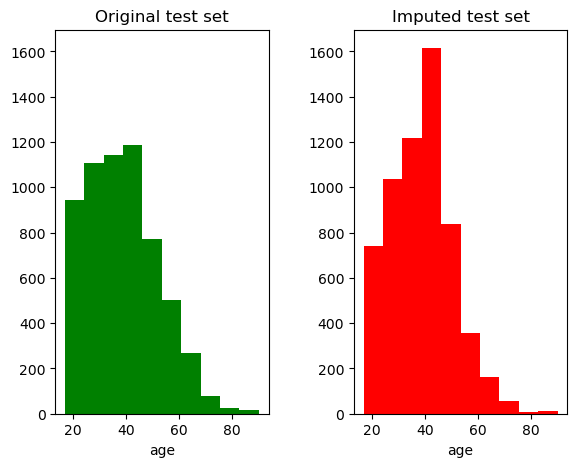

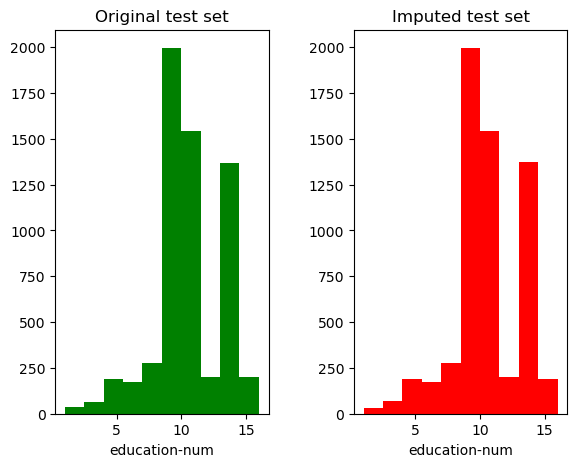

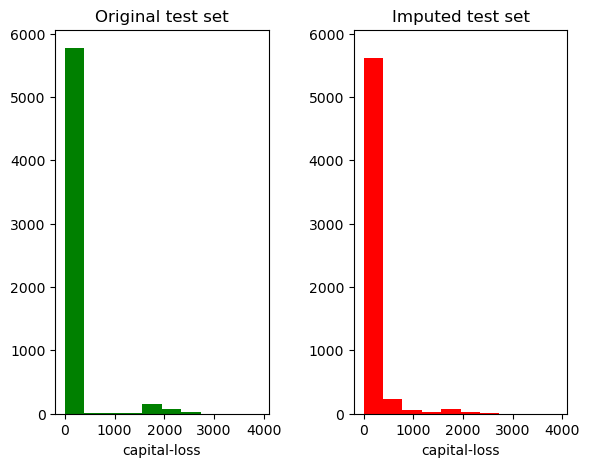

In [45]:
# Histograms: Numerical features

for i in selected_columns: #columns where we removed values to then impute them
    for j in num_features:
        if i == j: #to make the histogram of numerical features with imputed values:
            ax1 = plt.subplot(121, title = "Original test set", xlabel=i)
            ax1.hist(D_test[i], color = "green")
            ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1, title = "Imputed test set", xlabel=i)
            ax2.hist(df2_test[i], color = "red")

            plt.subplots_adjust(left=0.1, bottom = 0.1, top=0.9, wspace=0.4, hspace=0.4)
            plt.show()

Now, we will measure the quality of the imputation by the accuracy and the mean squared error on the test set.

In [46]:
# Metric: Accuracy

from sklearn.metrics import accuracy_score

# label encoding categorical features
label_encoding(df2_test, cat_features)
label_encoding(D_test, cat_features)


print("Numerical features: \n")
for i in num_features:
    for j in selected_columns:
        if i == j:
            acc_test_column = sklearn.metrics.accuracy_score(D_test[i], df2_test[i])
            print("Accuracy on feature " + i +" = " + str(round(acc_test_column*100,2)) + "%")
    
    


Numerical features: 

Accuracy on feature age = 51.16%
Accuracy on feature education-num = 99.47%
Accuracy on feature capital-loss = 66.49%


In [47]:
# Metric: Mean squared error

from sklearn.metrics import mean_squared_error

num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

# Fisrtly, we will normalize the values of the numerical features
for i in num_features:
    mean_d = np.mean(D_test[i])
    std_d = np.std(D_test[i])
    mean_d2 = np.mean(df2_test[i])
    std_d2 = np.std(df2_test[i])
    
    for j in df2_test[i].index:
        D_test[i][j] = (D_test[i][j] - mean_d)/std_d
        df2_test[i][j] = (df2_test[i][j] - mean_d2)/std_d2

# And now, we will calculate the mean square error
mse_test_num = 0
mse_test_cat = 0

for i in num_features:
    mse_test_column = mean_squared_error(D_test[i], df2_test[i])
    mse_test_num += mse_test_column
    
# For categorical features, we will assume the distance as 1 if the words to be compared are not equal, and 0 if they are
for j in cat_features:
    dist = 0
    for k in D_test.index:
        if D_test[j][k]==df2_test[j][k]:
            dist += 0
        else:
            dist += 1
    mse_test_cat += dist/len(D_test[j])      
    
        
print(mse_test_num)
print(mse_test_cat)
mse_test = mse_test_num + mse_test_cat
print("Mean squared error on test set = " + str(mse_test))

/tmp/ipykernel_8045/2878398597.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D_test[i][j] = (D_test[i][j] - mean_d)/std_d
/tmp/ipykernel_8045/2878398597.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test[i][j] = (df2_test[i][j] - mean_d2)/std_d2


1.0640194749920298
0.0
Mean squared error on test set = 1.0640194749920298
